In [1]:
#INITIALIZE SPARK SESSION
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PodPres").getOrCreate()

assembled_df = spark.read.parquet("final_features_human_labels.parquet")
assembled_df.printSchema()
assembled_df.show() 

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/11 20:37:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- segment_id: long (nullable = true)
 |-- podcast_name_cleaned: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: string (nullable = true)



+----------+--------------------+--------------------+-----+
|segment_id|podcast_name_cleaned|            features|label|
+----------+--------------------+--------------------+-----+
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.8|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.5|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.8|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|    1|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.7|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.2|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.4|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.5|
|         1|    pod save america|[10.0,-0.01585099...|  0.5|
|         1|    pod save america|[10.0,-0.01585099...|  0.7|
|         1|    pod save america|[10.0,-0.01585099...|  0.8|
|         1|    pod save america|[10.0,-0.01585099...|  0.1|
|         1|    pod save america|[10.0,-0.01585099...|  0.9|
|         1|    pod save

In [2]:
train_data, test_data = assembled_df.randomSplit([0.7, 0.3])
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

# Convert the data type of the 'label' column from string to float
train_data = train_data.withColumn("label", col("label").cast(FloatType()))
test_data = test_data.withColumn("label", col("label").cast(FloatType()))


In [3]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='label')
lrModel = lr.fit(train_data)


24/05/11 20:37:26 WARN Instrumentation: [2b58c1d5] regParam is zero, which might cause numerical instability and overfitting.
24/05/11 20:37:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/11 20:37:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/05/11 20:37:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/05/11 20:37:27 WARN Instrumentation: [2b58c1d5] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [4]:
from pyspark.sql.functions import col, count, lit

# Calculate the total number of rows to compute proportions
total_count = train_data.count()

# Group by the 'label' column and calculate the count of each label
label_distribution = train_data.groupBy("label").count()

# Calculate the percentage of each label
label_distribution = label_distribution.withColumn("percentage", (col("count") / lit(total_count) * 100))

# Display the results
label_distribution.show()


+-----+-----+------------------+
|label|count|        percentage|
+-----+-----+------------------+
|  0.1|   97|16.086235489220563|
|  0.6|   19| 3.150912106135987|
|  0.9|   73|12.106135986733001|
|  0.5|  105|17.412935323383085|
|  1.0|   56| 9.286898839137644|
|  0.3|   38| 6.301824212271974|
|  0.4|   24|3.9800995024875623|
|  0.8|   75|12.437810945273633|
|  0.2|   64|10.613598673300165|
|  0.0|   22|3.6484245439469323|
|  0.7|   30| 4.975124378109453|
+-----+-----+------------------+



In [5]:
# Get the statistical summary for the "label" column
train_data.describe("label").show()

+-------+-------------------+
|summary|              label|
+-------+-------------------+
|  count|                603|
|   mean| 0.5142620235162588|
| stddev|0.32153428188937944|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



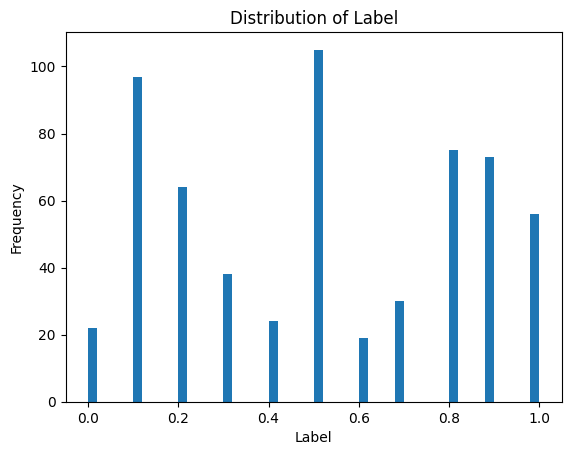

In [14]:
import matplotlib.pyplot as plt

# Retrieve the "label" data
label_data = train_data.select("label").rdd.flatMap(lambda x: x).collect()

# Plot the histogram
plt.hist(label_data, bins=50)  # bins参数根据数据的具体情况调整
plt.title('Distribution of Label')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()


In [6]:
# Use the trained model to make predictions on the test data
predictions = lrModel.transform(test_data)
# Display the first 20 prediction results alongside the actual label values
predictions.select("label", "prediction").show(20)

+-----+-------------------+
|label|         prediction|
+-----+-------------------+
|  0.2| 0.5849780585533232|
|  0.8| 0.5849780585533232|
|  0.0| 0.5117623970383736|
|  0.3| 0.5117623970383736|
|  0.7| 0.5117623970383736|
|  0.8| 0.5117623970383736|
|  0.1|0.43641893688005473|
|  0.3|0.43641893688005473|
|  0.5|0.43641893688005473|
|  0.9|0.43641893688005473|
|  0.1| 0.6829381313797196|
|  0.3| 0.6829381313797196|
|  0.5| 0.6829381313797196|
|  0.4| 0.3444479028914791|
|  0.1| 0.5040258353172603|
|  0.1| 0.3678750781352978|
|  0.1| 0.3678750781352978|
|  0.7| 0.3678750781352978|
|  0.8| 0.3678750781352978|
|  0.9| 0.3678750781352978|
+-----+-------------------+
only showing top 20 rows



In [7]:
test_data.describe("label").show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|               264|
|   mean|0.4867424244964213|
| stddev|0.3287468887383279|
|    min|               0.0|
|    max|               1.0|
+-------+------------------+



24/05/11 20:37:31 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [8]:
from pyspark.sql.functions import avg

# Calculate the average value of the 'prediction' column
trump_win_probability = predictions.agg(avg("prediction")).first()[0]

# Output the probability of Trump winning
print(f"Trump Win Probability: {trump_win_probability:.2f}")

biden_win_probability = 1-trump_win_probability

# Output the probability of Biden winning
print(f"Biden Win Probability: {biden_win_probability:.2f}")


Trump Win Probability: 0.51
Biden Win Probability: 0.49


In [9]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Create parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Set up cross-validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="label"),
                          numFolds=5)  # 使用3折交叉验证


# Run cross-validation to choose the best parameter combination
cvModel = crossval.fit(train_data)

# Save the model
#cvModel.bestModel.save("/Users/zhuyijie/Desktop/228/PodPresPred/")

# Make predictions using the best model
bestModelPredictions = cvModel.bestModel.transform(test_data)
bestModelPredictions.show()


+----------+--------------------+--------------------+-----+------------------+
|segment_id|podcast_name_cleaned|            features|label|        prediction|
+----------+--------------------+--------------------+-----+------------------+
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.2|0.5142620235162588|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.8|0.5142620235162588|
|         2|Bill OReillys No ...|[29.0,-0.03721171...|  0.0|0.5142620235162588|
|         2|Bill OReillys No ...|[29.0,-0.03721171...|  0.3|0.5142620235162588|
|         2|Bill OReillys No ...|[29.0,-0.03721171...|  0.7|0.5142620235162588|
|         2|Bill OReillys No ...|[29.0,-0.03721171...|  0.8|0.5142620235162588|
|         3|The Charlie Kirk ...|[20.0,-0.02749935...|  0.1|0.5142620235162588|
|         3|The Charlie Kirk ...|[20.0,-0.02749935...|  0.3|0.5142620235162588|
|         3|The Charlie Kirk ...|[20.0,-0.02749935...|  0.5|0.5142620235162588|
|         3|The Charlie Kirk ...|[20.0,-

In [10]:
from pyspark.sql.functions import avg

# Calculate the average value of the 'prediction' column
trump_win_probability_best = bestModelPredictions.agg(avg("prediction")).first()[0]

# Output the probability of Trump winning
print(f"Trump Win Probability: {trump_win_probability_best:.2f}")

biden_win_probability_best = 1-trump_win_probability_best

# Output the probability of Biden winning
print(f"Biden Win Probability: {biden_win_probability_best:.2f}")

Trump Win Probability: 0.51
Biden Win Probability: 0.49


In [11]:
from pyspark.ml.evaluation import RegressionEvaluator

# Create an evaluator instance to calculate RMSE
evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)

# Use the evaluator to calculate RMSE
rmse = evaluator.evaluate(bestModelPredictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")


Root Mean Squared Error (RMSE) on test data = 0.32927567783764006


In [12]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = bestModelPredictions.select("label", "prediction").toPandas()

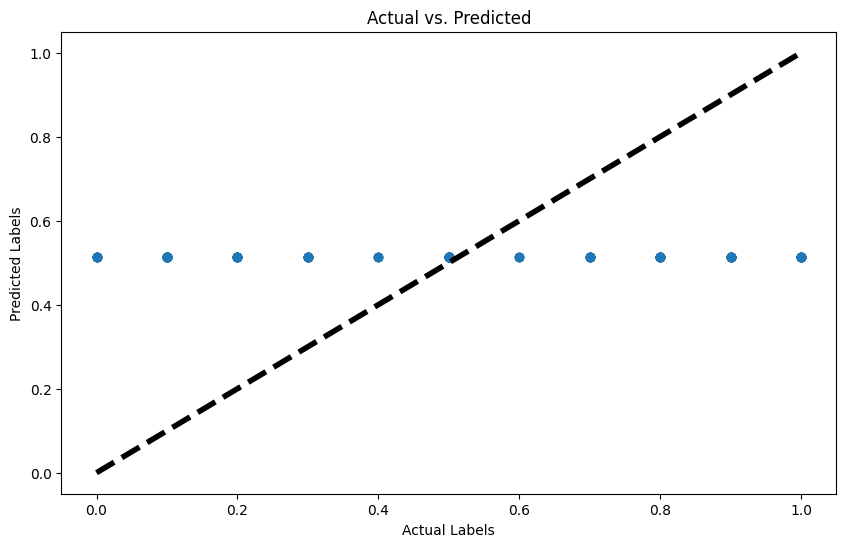

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['label'], pandas_df['prediction'], alpha=0.5)
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.plot([pandas_df['label'].min(), pandas_df['label'].max()], [pandas_df['label'].min(), pandas_df['label'].max()], 'k--', lw=4)
plt.show()
